PROJECT TITLE: DEPRESSION RISK CLASSIFICATION USING MACHINE LEARNING.

GOAL: To build a machine learning model that automatically classifies depression severity(Minimal, Mild, Moderate) based on patient responses to the PHQ-9 questionnaire.

DATASET: PHQ-9 Dataset from Mendeley

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#loading the dataset
df =pd.read_csv(r"C:\Users\ADMIN\Downloads\PHQ-9_Dataset_5th Edition.csv")


# Clean Headers
df.columns = df.columns.str.strip()

# We group columns by their name and keep only the first instance.
df = df.groupby(level=0, axis=1).first()

# 4. Define Questions
phq_questions = [
    'Little interest or pleasure in doing things',
    'Feeling down, depressed, or hopeless',
    'Trouble falling or staying asleep, or sleeping too much',
    'Feeling tired or having little energy',
    'Poor appetite or overeating',
    'Feeling bad about yourself—or that you are a failure or have let yourself or your family down',
    'Trouble concentrating on things, such as reading the newspaper or watching television',
    'Moving or speaking so slowly that other people could have noticed? Or the opposite—being so fidgety or restless that you have been moving around a lot more than usual',
    'Thoughts that you would be better off dead or of hurting yourself in some way'
]

# 5. Define Mapping
phq_mapping = {
    'Not at all': 0,
    'Several days': 1,
    'More than half the days': 2,
    'Nearly every day': 3
}

# Apply Cleaning & Mapping
for col in phq_questions:
    # Check if column exists to avoid KeyError
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().map(phq_mapping)

print("Success! Missing values in questions:", df[phq_questions].isna().sum().sum())
print(df[phq_questions].head())


Success! Missing values in questions: 0
   Little interest or pleasure in doing things  \
0                                            2   
1                                            0   
2                                            0   
3                                            3   
4                                            0   

   Feeling down, depressed, or hopeless  \
0                                     0   
1                                     0   
2                                     0   
3                                     3   
4                                     0   

   Trouble falling or staying asleep, or sleeping too much  \
0                                                  0         
1                                                  3         
2                                                  0         
3                                                  0         
4                                                  0         

   Feeling tired or having 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5996\1556778558.py:18: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(level=0, axis=1).first()


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 16 columns):
 #   Column                                                                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                                                                  --------------  ----- 
 0   Age                                                                                                                                                                     682 non-null    int64 
 1   Feeling bad about yourself—or that you are a failure or have let yourself or your family down                                                                           682 non-null    int64 
 2   Feeling down, depressed, or hopeless                                                                      

From the dataset above, we can see that it contains 682 individuals assessed using the PHQ-9 depression screening questionnaire along with contextual factors such as age, gender, sleep quality, study pressure, financial pressure. 

Also, each response is categorical, i.e, not at all, several days, more than half days and nearly every day. These are ordinal variables, not nominal.


We will now Prepare the Target(PHQ_Severity)

Our target variable is categorical(e.g. severe, mild). We map these categories to an ordered scale of: 

 0: None-Minimal

 1: Mild

 2: Moderate

 3: Moderately Severe

 4: Severe

In [6]:
#checking unique features to ensure we map correctly
print("Unique Severity Labels:", df['PHQ_Severity'].unique())

#Defining Target Mapping(ordinal)
severity_mapping = {
    'Minimal': 0,
    'Mild': 1,
    'Moderate': 2,
    'Moderately severe': 3,
    'Severe': 4,
    'None-minimal': 0 # Handling potential variation in data
}

# 3. Apply Mapping
df['Severity_Encoded'] = df['PHQ_Severity'].str.strip().map(severity_mapping)

# 4. Drop rows where target might be missing
df = df.dropna(subset=['Severity_Encoded'])

print("Target distribution:")
print(df['Severity_Encoded'].value_counts().sort_index())

Unique Severity Labels: ['Minimal' 'Moderately severe' 'Moderate' 'Mild' 'Severe']
Target distribution:
Severity_Encoded
0    206
1    155
2    128
3    125
4     68
Name: count, dtype: int64



We now move to Feature Selection and Splitting using Train-Test Split using stratify to ensure that all severity levels are represented proportionally in both sets. 

We will select only the 9 PHQ question responses as our input features(X) and exclude demographic data(Age, Gender) and derived scores(PHQ_Total) to ensure the model focuses on the symptoms solely.

In [7]:
from sklearn.model_selection import train_test_split

#defining features (X) and Target (y)
X = df[phq_questions]           # Only the 9 questions
y = df['Severity_Encoded']      # The encoded severity level

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size = 0.20, stratify=y,  random_state= 42
)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (545, 9)
Testing Data Shape: (137, 9)


We will train our model using Logistic Regression and use it as our Baseline Model. We will start by scaling our data which is crucial for logistic regression convergence, training and evaluation.

In [8]:
#  LOGISTIC REGRESSION BASELINE MODEL
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

# Create a Pipeline
log_reg_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
)

# Train the Baseline
log_reg_pipeline.fit(X_train, y_train)
print("Baseline Logistic Regression trained successfully.")

# Evaluate on Test Data
y_pred_baseline = log_reg_pipeline.predict(X_test)

# Print Results
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_acc:.4f}")

print("\nClassification Report (Baseline):")
print(classification_report(y_test, y_pred_baseline))

Baseline Logistic Regression trained successfully.
Baseline Accuracy: 0.9781

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        31
           2       1.00      0.96      0.98        26
           3       0.89      1.00      0.94        25
           4       1.00      0.86      0.92        14

    accuracy                           0.98       137
   macro avg       0.98      0.96      0.97       137
weighted avg       0.98      0.98      0.98       137



C:\Users\ADMIN\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


From the results above, we see that our baseline accuracy is 97.8% showing that the model is almost perfect. Recall is 0.86 meaning the model missed a few severe cases and class 3 (Moderately severe) precision is 0.89 suggiesting the model likely predicted those missing "severe" patients as "moderately severe" instead.

We will now visualize the errors using a confusion matrix. 

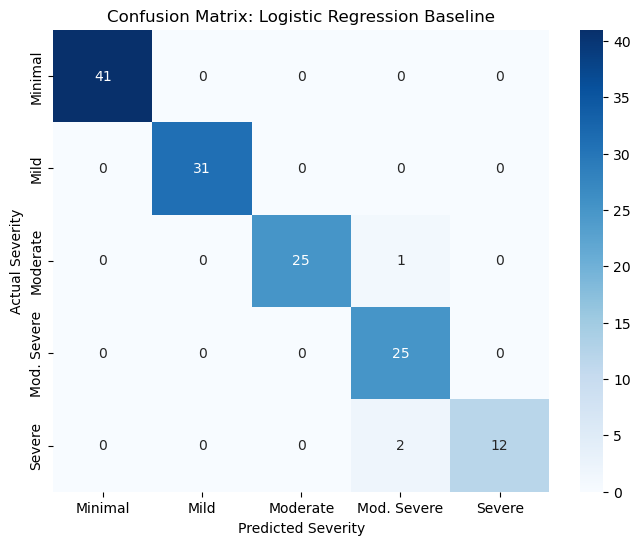

In [9]:
# --- STEP 4b: VISUALIZE BASELINE RESULTS ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)

# 2. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Minimal', 'Mild', 'Moderate', 'Mod. Severe', 'Severe'],
            yticklabels=['Minimal', 'Mild', 'Moderate', 'Mod. Severe', 'Severe'])

plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.title('Confusion Matrix: Logistic Regression Baseline')
plt.show()

From the Confusion Matrix above, we can see the following: 

Perfect for Low Severity: The model made 0 mistakes for "Minimal" and "Mild" cases.

The "Boundary" Struggle: The only errors are in the higher categories.

Look at the bottom-right: 2 "Severe" patients were predicted as "Mod. Severe".

1 "Moderate" patient was predicted as "Mod. Severe".

This is happening because Logistic regression draws a "smooth line" to separate classes but the PHQ-9 scoring system uses hard cut-offs, for example score 14 is moderate while score 15 is moderately severe. 

We now want to train a Random Forest Model to try and see if we will hit a 100% accuracy.

Random Forest Model trained successfully.
Random Forest Accuracy: 0.8321

Random Forest Confusion Matrix:


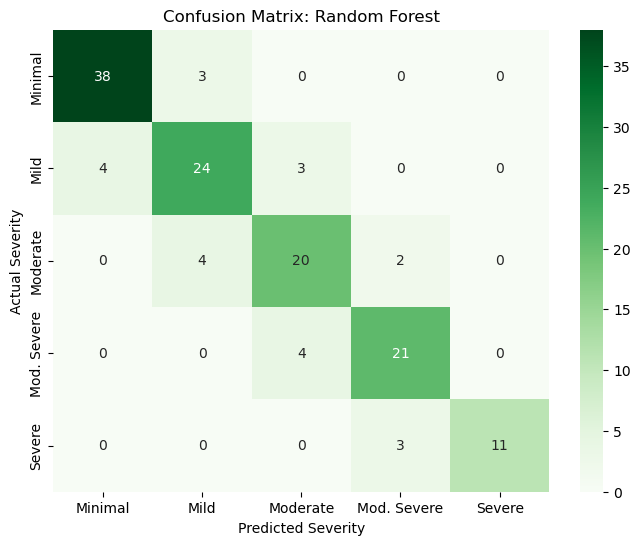

In [10]:
# RANDOM FOREST MODEL
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize Random Forest
# We use 100 trees (n_estimators) to ensure stability
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the Model
rf_model.fit(X_train, y_train)
print("Random Forest Model trained successfully.")

# 3. Predict
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluate
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

# 5. Visual Comparison
print("\nRandom Forest Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', # Using Green to distinguish from LogReg
            xticklabels=['Minimal', 'Mild', 'Moderate', 'Mod. Severe', 'Severe'],
            yticklabels=['Minimal', 'Mild', 'Moderate', 'Mod. Severe', 'Severe'])
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.title('Confusion Matrix: Random Forest')
plt.show()

From the results above, we can see that our Random Forest Model has an accuracy of 83%. This proves that our data structure is strictly linear and logistic regression works by calculating a weighted sum ($w_1x_1 + w_2x_2...$). Since the PHQ-9 severity is literally calculated by summing the scores, Logistic Regression fits it perfectly.

On the other hand, Random Forest works by making thousands of "If/Else" splits. For a simple summing task, it essentially "overthinks" the problem, chopping up the data into unnecessary complex rules, which leads to the confusion we see between adjacent classes (e.g., mistaking "Mild" for "Minimal")

The insight from this is that for clinical scoring tools based on sums, simple linear models are superior to complex ensemble models.

Support Vector Machines (SVM).

We will train SVM model using Linear kernel and see if it matches logistic regression accuracy. 

SVM (Linear) trained Successfully.
SVM (Linear) Accuracy: 0.9854


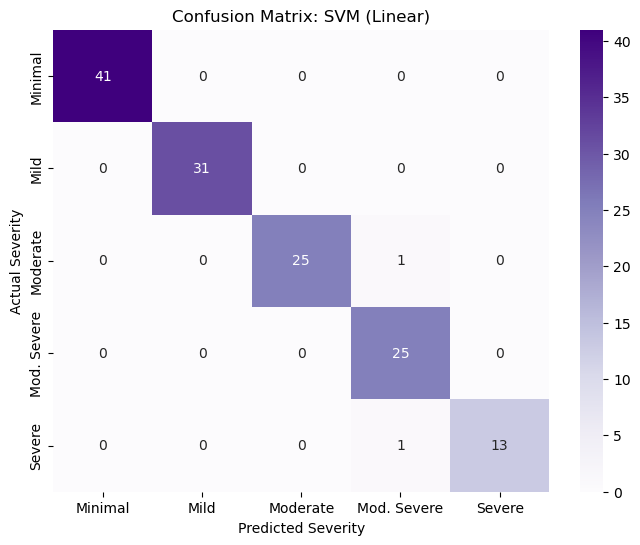

In [12]:
from sklearn.svm import SVC

#initialize SVM
# kernel='linear' forces it to find a straight line/plane, similar to LogReg
svm_model = SVC(kernel= 'linear', C=1.0, random_state = 42)

#Train
svm_model.fit(X_train, y_train)
print("SVM (Linear) trained Successfully.")

#Evaluate
y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)

print(f"SVM (Linear) Accuracy: {svm_acc:.4f}")

# Visual Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Minimal', 'Mild', 'Moderate', 'Mod. Severe', 'Severe'],
            yticklabels=['Minimal', 'Mild', 'Moderate', 'Mod. Severe', 'Severe'])
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.title('Confusion Matrix: SVM (Linear)')
plt.show()

From the results above, we can see that the Linear SVM model performed better than Logistic regression and Random Forest. We can easily conclude that the relationship between PHQ-9 Questions and Depression Severity is strictly linear.